# 🧩 PCA on scFoundation Embeddings

In this notebook, we apply Principal Component Analysis (PCA) to the scFoundation embeddings to reduce their dimensionality and prepare them for merging with our bulk dataset.


In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


## 📥 Load Embeddings and Sample Metadata

We load the scFoundation `.npy` embeddings and a corresponding file containing `SANGER_MODEL_ID` to retain sample identity.


In [11]:
embedding_path = "../../data/embeddings/bulk_embeddings_voom.npy"  # Update if needed
sample_ids_path = "../../data/processed/voom_transformed_data.parquet"  # Should contain SANGER_MODEL_ID in correct order

embeddings = np.load(embedding_path)
sample_ids = pd.read_parquet(sample_ids_path)  # Should match the shape of embeddings

print("Embeddings shape:", embeddings.shape)
print("Sample IDs shape:", sample_ids.shape)
assert embeddings.shape[0] == sample_ids.shape[0], "Mismatch in sample count!"


Embeddings shape: (1362, 3072)
Sample IDs shape: (1362, 37602)


## 🧪 Apply PCA

We'll reduce the embedding dimensionality to the top 20 principal components.


In [12]:
NUM_PCS = 100

pca_full = PCA(n_components=NUM_PCS, random_state=42)
pca_full_result = pca_full.fit_transform(embeddings)

print("Full PCA shape:", pca_full_result.shape)


Full PCA shape: (1362, 100)


## 📊 Explained Variance

Let's check how much variance each principal component captures.


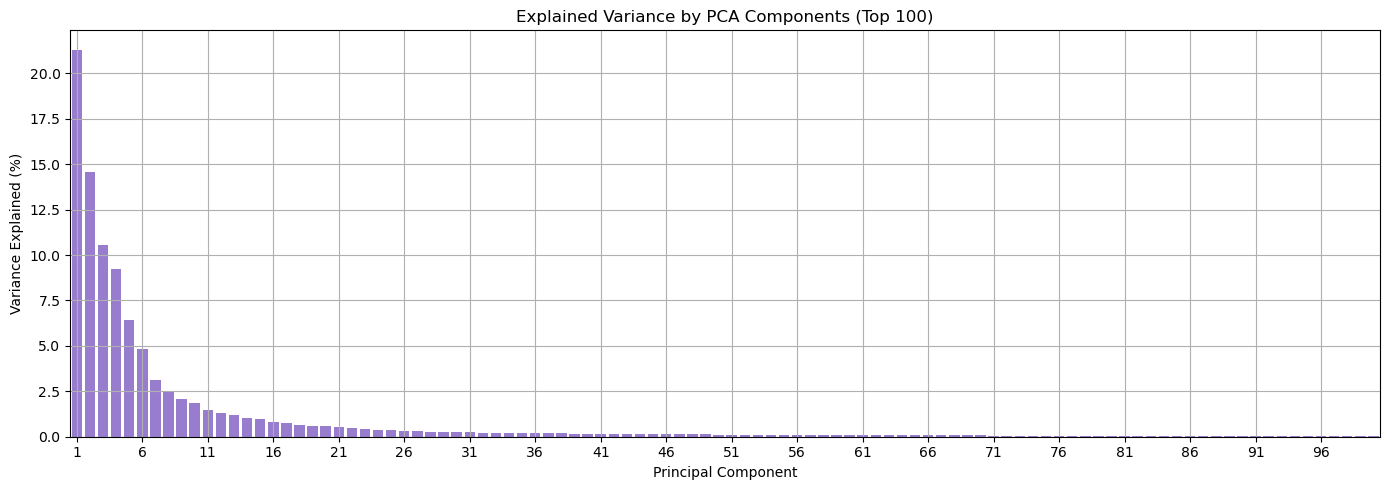

In [13]:
# Visualize variance explained by each of the top 100 components
plt.figure(figsize=(14, 5))
sns.barplot(
    x=np.arange(1, NUM_PCS + 1),
    y=pca_full.explained_variance_ratio_ * 100,
    color="mediumpurple"
)
plt.title("Explained Variance by PCA Components (Top 100)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.xticks(ticks=np.arange(0, NUM_PCS, 5), labels=[str(i+1) for i in range(0, NUM_PCS, 5)])
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Cumulative Explained Variance

This plot shows how much of the total variance is captured as we increase the number of principal components.


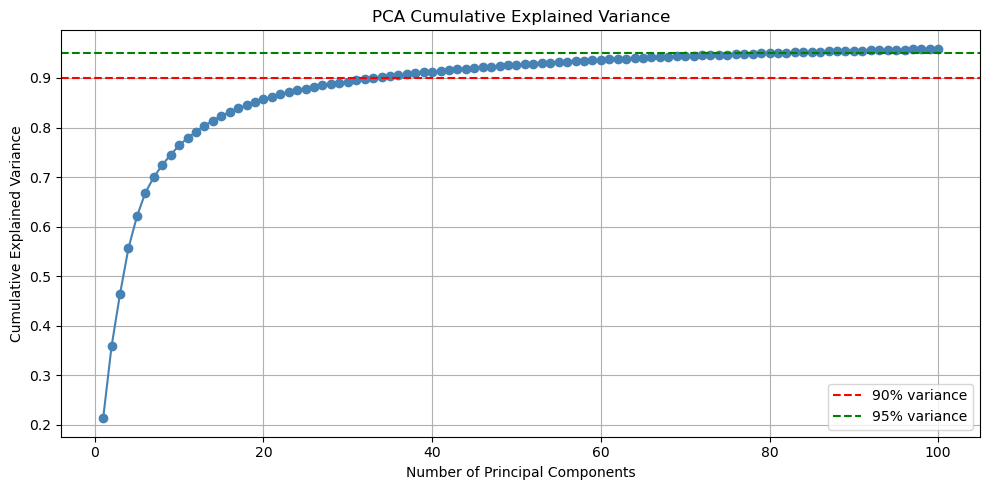

In [14]:
# Calculate and plot cumulative explained variance
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_PCS + 1), cumulative_var, marker="o", color="steelblue")
plt.axhline(0.9, linestyle="--", color="red", label="90% variance")
plt.axhline(0.95, linestyle="--", color="green", label="95% variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 🎯 Decide on Number of Principal Components

Based on the explained variance and cumulative plots, we now choose how many PCs to use for modeling.


In [20]:
# Pick number of components based on your decision (e.g., 20, 30, 50...)
SELECTED_PCS = 30  # 👈 Update this number based on your study

pca = PCA(n_components=SELECTED_PCS, random_state=42)
pca_transformed = pca.fit_transform(embeddings)

# Save the PCA-transformed data with the selected number of components
pcs_df = pd.DataFrame(
    pca_transformed,
    columns=[f"SCF_PC{i+1}" for i in range(SELECTED_PCS)]
)

print(sample_ids.head())
pcs_df["SANGER_MODEL_ID"] = sample_ids.index


gene_id          SIDG00001  SIDG00002  SIDG00003  SIDG00004  SIDG00005  \
SANGER_MODEL_ID                                                          
SIDM00001        -6.793635   1.131178  -3.986280  -0.526848  -6.793635   
SIDM00002        -0.093907   2.296382  -8.346572   0.502050  -1.108168   
SIDM00003        -0.600179   3.433112  -8.560181  -8.560181  -0.683664   
SIDM00005         1.455215   2.164904  -5.183824   0.242441   1.355335   
SIDM00006        -0.629975   2.634419  -4.031226   7.340196  -0.549163   

gene_id          SIDG00006  SIDG00007  SIDG00008  SIDG00009  SIDG00010  ...  \
SANGER_MODEL_ID                                                         ...   
SIDM00001        -5.208672  -6.793635  -6.793635  -6.793635  -6.793635  ...   
SIDM00002         0.249617  -6.761610  -6.024644  -6.761610  -1.660072  ...   
SIDM00003        -6.238253  -8.560181  -8.560181  -4.472718  -3.202629  ...   
SIDM00005        -1.639503  -3.961432  -0.428936  -3.961432  -3.068347  ...   
SIDM000

In [21]:
import polars as pl

# 📥 Load GDSC drug response data
gdsc_bulk = pl.read_parquet("../../data/processed/gdsc_final_cleaned.parquet").select([
    pl.col("SANGER_MODEL_ID").cast(pl.Utf8),
    pl.col("DRUG_ID").cast(pl.Int32),
    pl.col("LN_IC50").cast(pl.Float32)
])

# Convert pcs_df to Polars DataFrame before joining
pcs_df_pl = pl.from_pandas(pcs_df)

# 🔗 Merge PCA-transformed cell line profiles with GDSC drug response
merged = gdsc_bulk.join(pcs_df_pl, on="SANGER_MODEL_ID", how="left")

# ✅ Confirm merge
print("✅ Merged GDSC with PCA-transformed expression.")
print(f"Final shape: {merged.shape}")
print(merged.head())

# 💾 Save the merged dataset
merged.write_parquet("../../data/processed/bulk_with_voom_pca_embeddings.parquet")
print("📁 Saved merged dataset to 'bulk_with_pca.parquet'")


✅ Merged GDSC with PCA-transformed expression.
Final shape: (571985, 33)
shape: (5, 33)
┌─────────────┬─────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ SANGER_MODE ┆ DRUG_ID ┆ LN_IC50  ┆ SCF_PC1   ┆ … ┆ SCF_PC27  ┆ SCF_PC28  ┆ SCF_PC29  ┆ SCF_PC30  │
│ L_ID        ┆ ---     ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ ---         ┆ i32     ┆ f32      ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
│ str         ┆         ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
╞═════════════╪═════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SIDM00263   ┆ 1       ┆ 3.966813 ┆ -4.465111 ┆ … ┆ 0.29754   ┆ -0.124258 ┆ -0.274846 ┆ 0.154977  │
│ SIDM00269   ┆ 1       ┆ 2.69209  ┆ -1.701702 ┆ … ┆ -0.010056 ┆ -0.147033 ┆ -0.587825 ┆ -0.087653 │
│ SIDM00203   ┆ 1       ┆ 2.47799  ┆ -4.912833 ┆ … ┆ 0.146833  ┆ -0.308752 ┆ -0.499542 ┆ -0.11602  │
│ S

## ✅ Done

We now have PCA-transformed scFoundation embeddings ready to merge with our main dataset.
